In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index: #если превысили, считаем заново(когда наступает след.эпоха)
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index)) #окно 168-311(=144)
            i += len(rows) #+=144

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows): # j=0-batch_size row=168...end
            
            indices = range(rows[j] - lookback, rows[j], step)#168-lookback,168
                                                                #169-lookback,169
   
            samples[j] = data[indices] #окно 0-168 1-169 2-170... кол-во окон=batch_size 
            targets[j] = data[rows[j] + delay][1] #цена на след.день после 7ми дней
        yield samples, targets

In [2]:
df = pd.read_csv(r"C:\Users\1\Downloads\RU_Electricity_Market_PZ_dayahead_price_volume.csv")
df=df.drop(columns=['consumption_sib','price_sib'])
df=df.set_index('timestep')
#Обработка пропущенных значений
one_day = 60 * 24
for row in range(df.values.shape[0]):
    for col in range(df.values.shape[1]):
        if np.isnan(df.values[row, col]):
            df.values[row, col] = df.values[row - one_day, col]
#Нормализация

scaler=StandardScaler()
data_scaled=scaler.fit_transform(df)
means=scaler.mean_
std=scaler.scale_

lookback=168 #кол-во временных участков, 
#на основании которых делаем прогноз
step=1 #шаг окна
delay=0 #кол-во прогнозируемых временных участков
batch_size=128 #Размер пакета
#Разбивка данных на выборки
train_split=int(0.6*len(data_scaled))
train=train_split-(train_split%batch_size)
val_split=int(0.8*len(data_scaled))
val=val_split-(val_split%batch_size)
test_split=(len(data_scaled))
test=test_split-(test_split%batch_size)
train_gen = generator(data_scaled,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=train,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(data_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=train+1,
                    max_index=val,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(data_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=val+1,
                    max_index=test+1,
                    step=step,
                    batch_size=batch_size)
#Сколько раз нужно обратится к вал.выборке
val_steps=(val-train-1-lookback)//batch_size
#Сколько раз нужно обратится к тест.выборке
test_steps=(test+1-val-1)//batch_size
print(val_steps)
print(test_steps)
lookback // step, data_scaled.shape[-1]

70
71


(168, 2)

In [3]:
from keras.models import Sequential
from keras import layers,metrics
model = Sequential()
model.add(layers.LSTM(8,input_shape=( lookback // step, data_scaled.shape[-1])))
# model.add(layers.LSTM(4,return_sequences=False,stateful=False))
model.add(layers.Dense(1))
model.summary()
model.compile(loss='mse', optimizer='adam') 
history = model.fit(train_gen,
                              steps_per_epoch=100,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)
# LSTM Params = 4*((num_features used+1)*num_units+ num_units^2)
# Dense params =output_channel_number * (input_channel_number + 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 352       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
100/100 [==============================] - 8s 81ms/step - loss: 0.5084 - val_loss: 0.5897
Epoch 2/40
100/100 [==============================] - 9s 93ms/step - loss: 0.2866 - val_loss: 0.4233
Epoch 3/40
100/100 [==============================] - 8s 77ms/step - loss: 0.1986 - val_loss: 0.3079
Epoch 4/40
100/100 [==============================] - 8s 76ms/step - loss: 0.1534 - val_loss: 0.2172
Epoch 5/40
100/100 [==============================] - 8s 75ms/step - loss: 0.1111 - val_loss: 0.1388
Epoch 6/40
100/

In [4]:
# ar=model.predict_generator(test_gen,steps=test_steps)
# mse_array=[]
# for ii in range(test_steps):
#     samples, targets = next(test_gen)
#     mse =(ar - targets)**2
  
#     mse_array.append(mse)


Instructions for updating:
Please use Model.predict, which supports generators.


(9088, 1)

In [41]:
arr=model.predict_generator(test_gen,steps=test_steps).flatten()
real_test = data_scaled[val+1:test+1,1]
mse_arr=[]

for ii in range(len(arr)):
    mse =(arr[ii] - real_test[ii])**2
    mse_arr.append(mse)
print("MSE= ",np.sum(mse_arr)/len(arr))

MSE=  0.13890301616308015


In [42]:
import matplotlib.pyplot as plt
for i in  range(len(arr)):
    arr[i]=(arr[i]*std[1])+means[1]
    real_test[i]=(real_test[i]*std[1])+means[1]


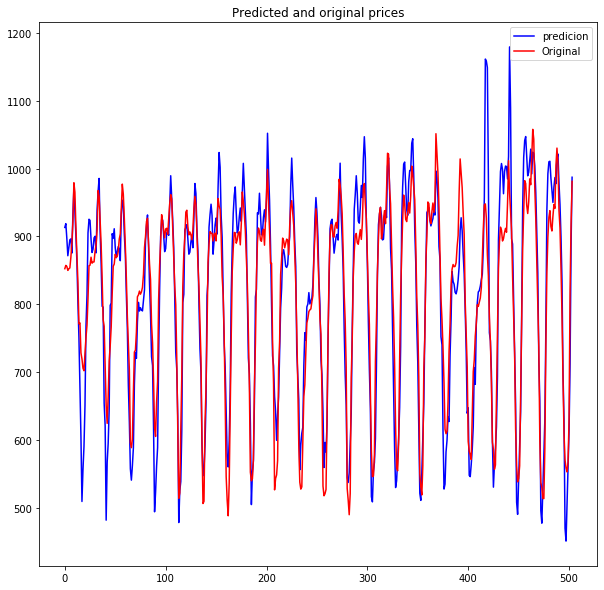

In [43]:
epochs = range(504)

plt.figure(figsize=(10,10))
plt.plot(epochs, arr[:504], 'b', label='predicion')
plt.plot(epochs, real_test[:504], 'r', label='Original')
plt.title('Predicted and original prices')
plt.legend()

plt.show()

MSE=  7.120507323508902
(70, 128)
(70, 128)


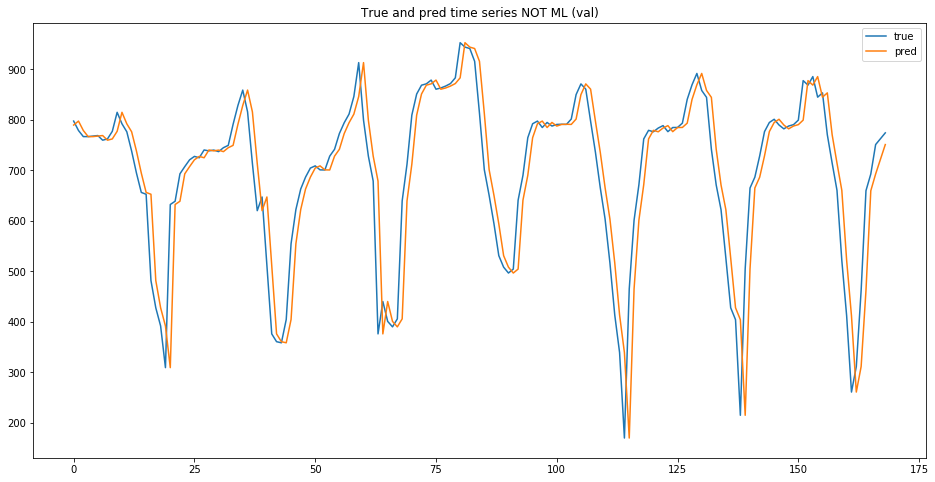

In [45]:
mse_array=[]
pred=[]
targets_array=[]
for step in range(val_steps):
    
    samples,targets=next(val_gen) 
    preds=samples[:,-1,1] 
    mse=(preds-targets)**2
    mse_array.append(mse)
    pred.append(preds)
    targets_array.append(targets)
print("MSE= ",np.sum(mse_array)/len(mse_array))
targets_array=np.asarray(targets_array)
pred=np.asarray(pred)
print(targets_array.shape)
print(pred.shape)
val_true = targets_array.reshape(len(targets_array)*batch_size)
val_pred = pred.reshape(len(pred)*batch_size)
for i in  range(len(val_true)):
    val_true[i]=(val_true[i]*std[1])+means[1]
    val_pred[i]=(val_pred[i]*std[1])+means[1]
x = np.linspace(0,168,168,dtype=int)
plt.figure(figsize=(16,8))
plt.plot(x, val_true[:168])
plt.plot(x, val_pred[:168])
plt.title('True and pred time series NOT ML (val)')
plt.legend(['true','pred'],loc='upper right')
plt.show()

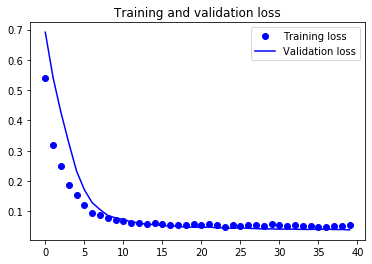

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()